[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jusepulveda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset sample:
                   question  \
0  What is (are) Glaucoma ?   
1    What causes Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
Initializing summarization models...


Device set to use mps:0


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use mps:0


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use mps:0



Question: What is (are) Glaucoma ?

Original Answer (truncated): Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage syste...

Generating summaries with all models...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Evaluating summaries...

Model Performance Comparison:
        Model   ROUGE-1   ROUGE-2   ROUGE-L  Avg_ROUGE
0  DistilBART  0.280423  0.271277  0.280423   0.277374
1     PEGASUS  0.259947  0.229333  0.254642   0.247974
2        BART  0.252011  0.215633  0.252011   0.239885

Best performing model: DistilBART

BART Summary:
Glaucoma is a group of diseases that can damage the eye's optic nerve. Most of these involve the drainage system within the eye. The most common type is called open-angle glaucomA. There is no cure for the disease, but there are treatments that may save vision.

PEGASUS Summary:
Glaucoma is a group of diseases that can damage the eye's optic nerve .<n>Most types of glaucoma involve the drainage system within the eye .<n>Most common type of glaucoma is called open-angle glaucoma .<n>There is no cure for glaucoma. Vision lost from the disease cannot be restored .

DistilBART Summary:
 Glaucoma is a group of diseases that can damage the eye's optic nerve . Most of these

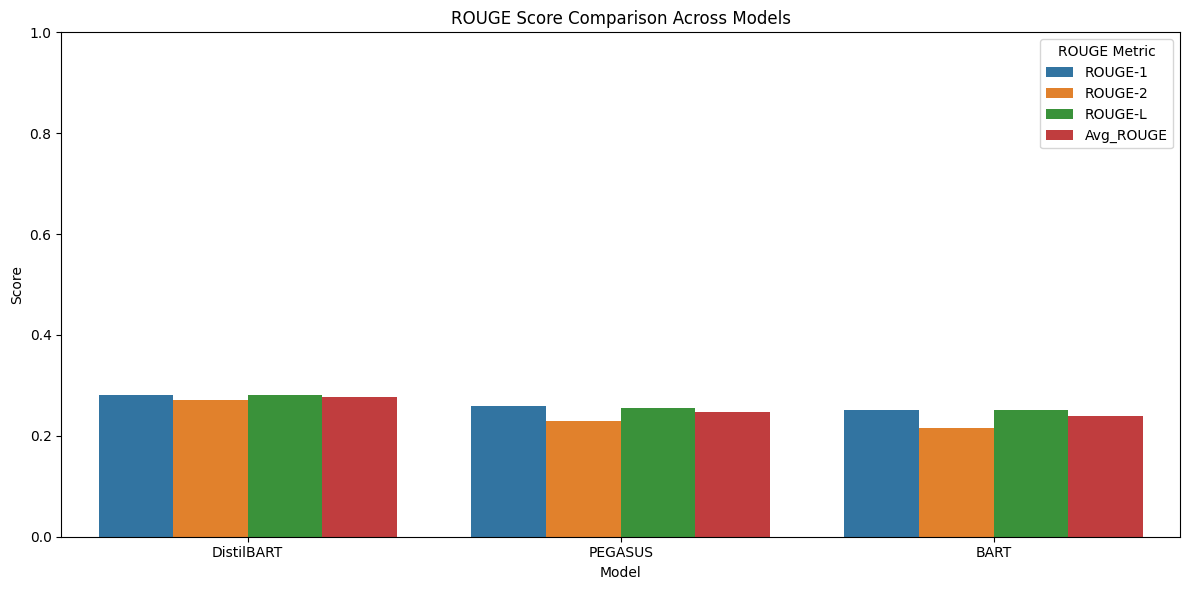

In [1]:
# Import necessary libraries
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from rouge_score import rouge_scorer

# Download NLTK resources if not already downloaded
nltk.download('punkt')

# Load dataset
path = '../data/medquad.csv'
df = pd.read_csv(path)
print("Dataset sample:")
print(df.head(2))

# Initialize all three summarization models
print("Initializing summarization models...")
bart_pipeline = pipeline("summarization", model="facebook/bart-large-cnn")
pegasus_pipeline = pipeline("summarization", model="google/pegasus-cnn_dailymail")
distilbart_pipeline = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Function to generate summaries using different models
def generate_summary(text, model_pipeline, max_length=150, min_length=50):
    result = model_pipeline(text, max_length=max_length, min_length=min_length, do_sample=False)
    return result[0]['summary_text']

# Function to calculate ROUGE scores for evaluating the summary
def evaluate_summary(reference, generated_summary):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = scorer.score(reference, generated_summary)
    return scores

# Get the sample text to summarize
index = 0  # Change this to analyze different examples
question = df.loc[index, 'question']
answer = df.loc[index, 'answer']

print(f"\nQuestion: {question}")
print(f"\nOriginal Answer (truncated): {answer[:300]}...\n")

# Generate summaries with all three models
print("Generating summaries with all models...")
bart_summary = generate_summary(answer, bart_pipeline)
pegasus_summary = generate_summary(answer, pegasus_pipeline)
distilbart_summary = generate_summary(answer, distilbart_pipeline)

# Evaluate all three summaries
print("Evaluating summaries...")
bart_scores = evaluate_summary(answer, bart_summary)
pegasus_scores = evaluate_summary(answer, pegasus_summary)
distilbart_scores = evaluate_summary(answer, distilbart_summary)

# Create a dataframe to compare the metrics
models = ['BART', 'PEGASUS', 'DistilBART']
rouge1 = [bart_scores['rouge1'].fmeasure, pegasus_scores['rouge1'].fmeasure, distilbart_scores['rouge1'].fmeasure]
rouge2 = [bart_scores['rouge2'].fmeasure, pegasus_scores['rouge2'].fmeasure, distilbart_scores['rouge2'].fmeasure]
rougeL = [bart_scores['rougeL'].fmeasure, pegasus_scores['rougeL'].fmeasure, distilbart_scores['rougeL'].fmeasure]

comparison_df = pd.DataFrame({
    'Model': models,
    'ROUGE-1': rouge1,
    'ROUGE-2': rouge2,
    'ROUGE-L': rougeL
})

# Calculate average ROUGE score for ranking
comparison_df['Avg_ROUGE'] = comparison_df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']].mean(axis=1)
comparison_df = comparison_df.sort_values('Avg_ROUGE', ascending=False).reset_index(drop=True)

print("\nModel Performance Comparison:")
print(comparison_df)

# Select the best model
best_model = comparison_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model}")

# Display summaries from all models
print("\nBART Summary:")
print(bart_summary)
print("\nPEGASUS Summary:")
print(pegasus_summary)
print("\nDistilBART Summary:")
print(distilbart_summary)

# Visualize the ROUGE scores
plt.figure(figsize=(12, 6))

# Create the bar plot
comparison_melted = pd.melt(comparison_df, id_vars=['Model'], 
                          value_vars=['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Avg_ROUGE'],
                          var_name='Metric', value_name='Score')
                          
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_melted)
plt.title('ROUGE Score Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)  # ROUGE scores range from 0 to 1
plt.xticks(rotation=0)
plt.legend(title='ROUGE Metric')
plt.tight_layout()
plt.show()